In [1]:
import sys
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git\\TP4_ECAL-\\utils')
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git\\TP4_ECAL-\\tracking')
from data_loading import *
from tqdm import tqdm
from hit import Hit
from track3D import Track3D
from matplotlib import pyplot as plt


file_path = 'C:\\Users\\Pascal\\Desktop\\TP4a\\git\\test_data_loading\\data_0000.root' 
import pandas as pd
import uproot
import numpy as np

In [2]:
br_list_data = ['n_hits', 'tofpet_id', 'tofpet_channel', 'timestamp', 't_coarse', 't_fine', 'timestamp', 'v_coarse', 'v_fine', 'value']
br_list_evt = ['timestamp', 'evt_number', 'evt_flags']
evt_tree = 'event_data;1'
hits_tree = 'event_data;1'

In [3]:
with uproot.open(file_path) as tree:
    hits_dict = tree[hits_tree].arrays(br_list_data, library="np")
    evts_dict = tree[evt_tree].arrays(br_list_evt, library="np")
    
df_evts = pd.DataFrame.from_dict(evts_dict)
df_hits = pd.DataFrame.from_dict(hits_dict)
df_hits['timestamp_event'] = df_evts['timestamp']

In [4]:
def create_tracks(df, plot = False):
    tracks = []
    nb_events = len(df['n_hits'])
    steps = 9
    buff_start = None
    buff_evt_idx = None
    dts = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0]):
        channels = row['tofpet_channel']
        tofpet_id = row['tofpet_id']
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D(hits)
            tracks.append(track)

            ## check if track has a "good" chi2 value
            if track.is_good_2D_fit():
            
                # worth making a precise track
                #track.precise_track()
                
                ## compute the time of the track
                dt = track.get_time_interval()
                if dt is not None:
                    dts.append(dt)


    return tracks, dts
    

In [5]:
tracks, dts = create_tracks(df_hits)

  0%|          | 0/2621 [00:00<?, ?it/s]

100%|██████████| 2621/2621 [00:37<00:00, 69.69it/s] 


####### Track # 426
Reduced chi^2 = 0.50
t = 0.33,	 x0 = 26.38
Reduced chi^2 = 0.50
t = -0.58,	 x0 = 15.49


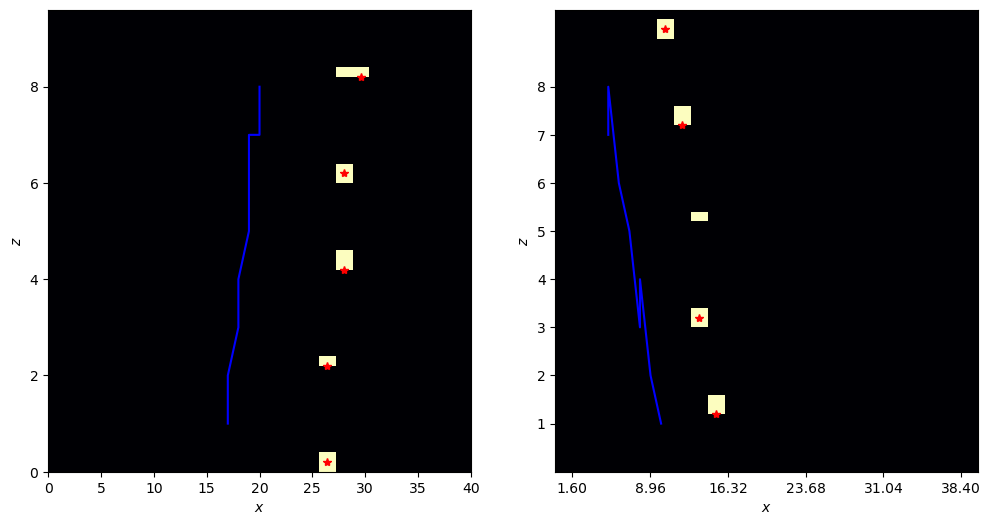

In [6]:
# testing individual outputs
good_tracks = [t for t in tracks if t.is_good_2D_fit()]
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
t.print(True)
# t.precise_track()
# print('after')
# t.print(True)

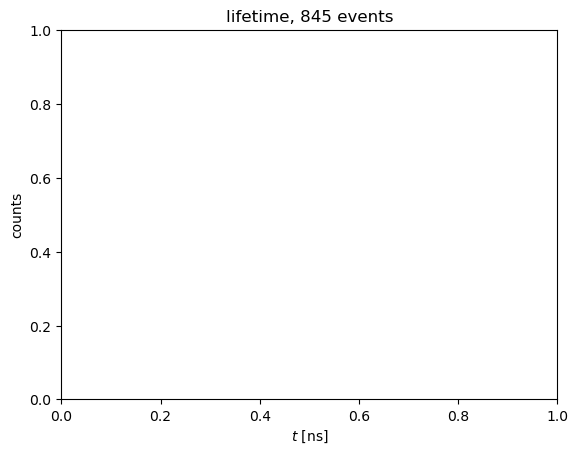

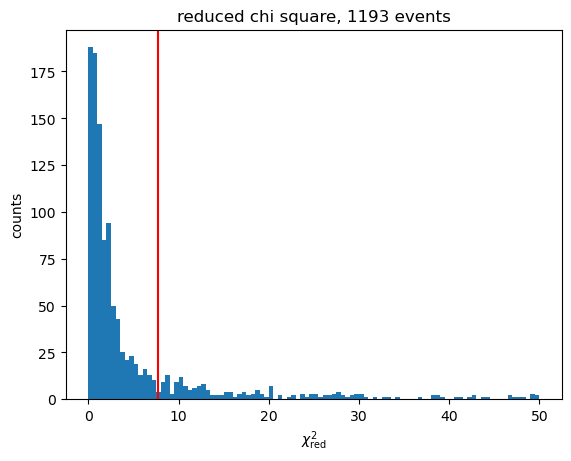

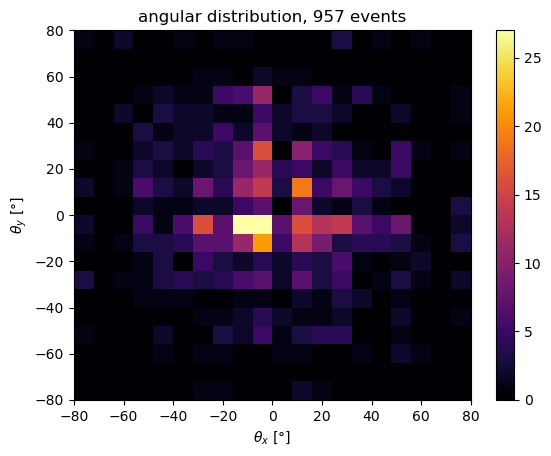

In [7]:
# plotting lifetime and reduced chi-square distribution
plt.figure()
plt.title('lifetime, {} events'.format(len(dts)))
# plt.hist(np.array(dts)*6.25, bins = 20)
# plt.yscale('log')
plt.xlabel('$t$ [ns]')
plt.ylabel('counts')

chi_squares = [track.reduced_chi2() for track in tracks if track.reduced_chi2() is not None]
plt.figure()
plt.title('reduced chi square, {} events'.format(len(chi_squares)))
plt.hist(chi_squares, bins = 100, range = [0, 50])
plt.axvline(x = 2 * 3.841, ymin = 0.0, ymax = 1.0, color = 'r')
plt.xlabel('$\chi^2_{\mathrm{red}}$')
plt.ylabel('counts')

thetas_x = [np.tan(t.x.t) * 180 / np.pi for t in tracks if t.is_good_2D_fit()]
thetas_y = [np.tan(t.y.t) * 180 / np.pi for t in tracks if t.is_good_2D_fit()]
plt.figure()
plt.title('angular distribution, {} events'.format(len(thetas_x)))
plt.hist2d(thetas_x, thetas_y, bins = 20, range = [[-80, 80], [-80, 80]], cmap = 'inferno')
plt.xlabel(r"$\theta_x$ [°]")
plt.ylabel(r"$\theta_y$ [°]")
plt.colorbar()

In [8]:
# testing the Kalman filter
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
t.kalman_filter()

####### Track # 1153
d =  2.4921056879736994
d =  2.2320452381652234


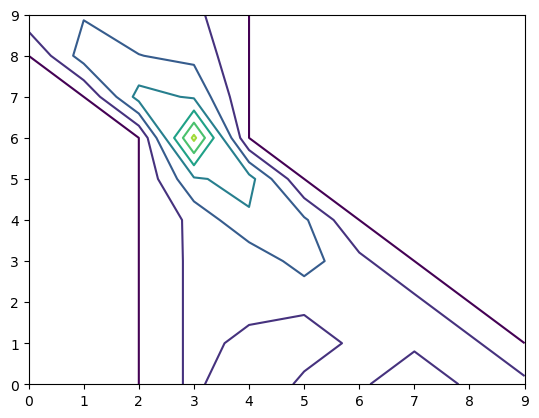

In [9]:
from parameters import *

tt = t.x
sampling = 10
angle_sampling = 10
max=5 # => angle scanning between [-78.7°,78,7°]
T = np.linspace(-max, max, angle_sampling, False)
x0s = np.empty(len(tt.hits) * sampling * sampling * angle_sampling)
txs = np.empty(len(tt.hits) * sampling * sampling * angle_sampling)
for n, hit in enumerate(tt.hits):
    zs = np.linspace(hit.get_pos()[1] - 0.5*thickness, hit.get_pos()[1] + 0.5*thickness, sampling)
    xs = np.linspace(hit.get_pos()[0] - 0.5*width, hit.get_pos()[0] + 0.5*width, sampling)
    for i, z in enumerate(zs):
        for j, x in enumerate(xs):
            index_prefix = n * sampling * sampling * angle_sampling + \
                i * sampling * angle_sampling + j * angle_sampling
            x0s[index_prefix:index_prefix +
                angle_sampling] = x - T * z
            txs[index_prefix:index_prefix + angle_sampling] = T

H, ts, xs = np.histogram2d(txs, x0s, bins=[angle_sampling, angle_sampling])
id_t, id_x0 = np.unravel_index(np.argmax(H, axis=None), H.shape)
t0 = ts[id_t] + (ts[1]-ts[0])/2
x0 = xs[id_x0] + (xs[1]-xs[0])/2

plt.contour(H)
plt.show()

c:\Users\Pascal\mambaforge\envs\ecal.env\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
c:\Users\Pascal\mambaforge\envs\ecal.env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


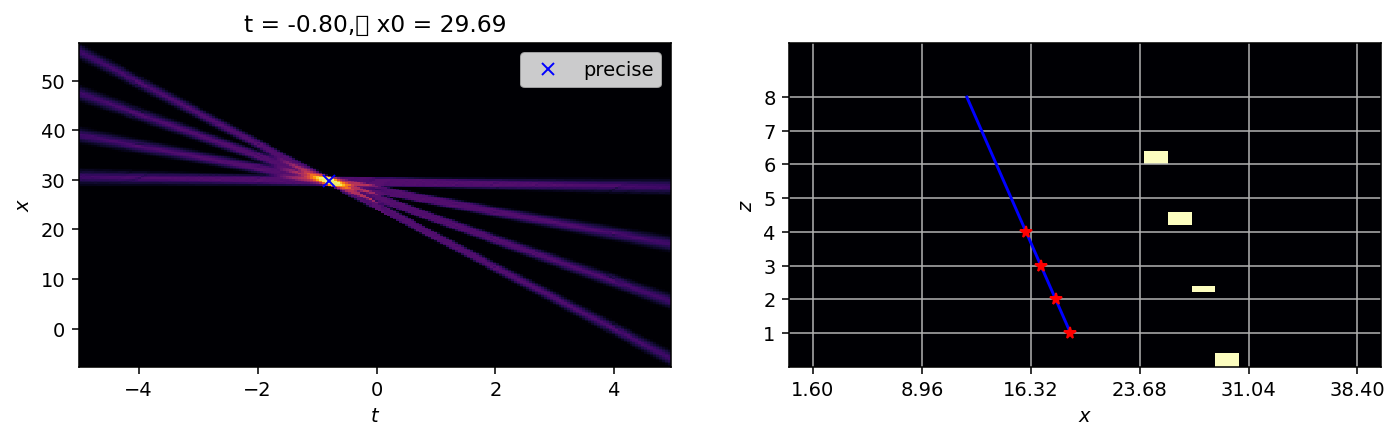

In [31]:
t = tracks[6]
tt = t.x
tt.find_track(15,200,True)

[Text(0.5, 0, '$x$'), Text(0, 0.5, '$z$')]

c:\Users\Pascal\mambaforge\envs\ecal.env\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
c:\Users\Pascal\mambaforge\envs\ecal.env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


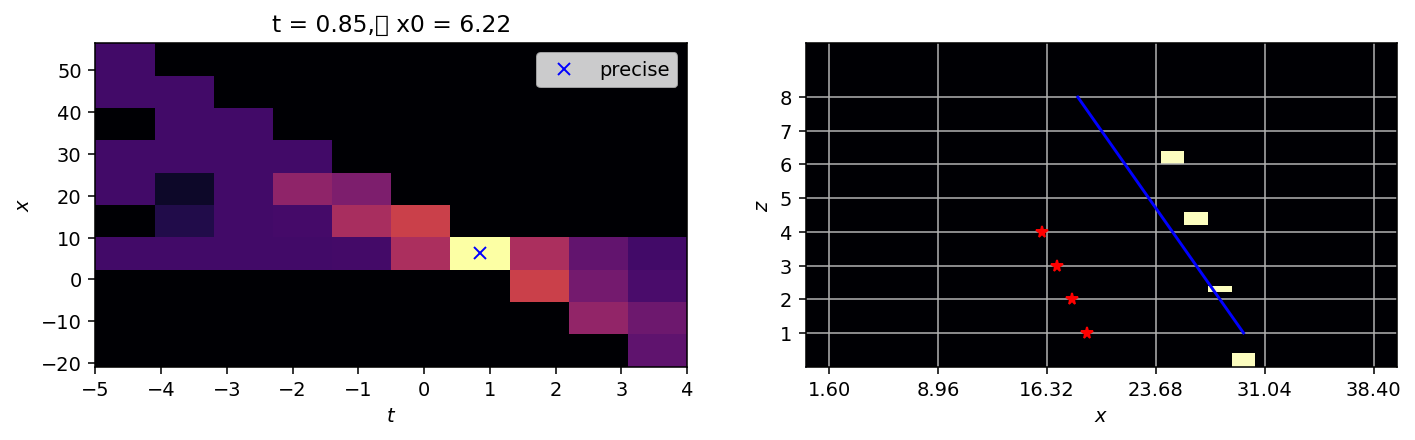

In [44]:
fit = tt.get_tracks()

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 3, forward=True)
fig.set_dpi(140)
axs[0].set_title('t = {:.2f},\t x0 = {:.2f}'.format(t0, x0))
# axs[0].hist2d(txs, x0s, bins=int(2 * angle_sampling / maxi), cmap='inferno', range=[[self.t - 2, self.t+2], [self.x0-10, self.x0+10]])
axs[0].hist2d(txs, x0s, bins = angle_sampling, cmap = 'inferno')
axs[0].plot([t0], [x0], 'bx', label='precise')
axs[0].set(xlabel='$t$', ylabel='$x$')
axs[0].legend()

hitsX = [hit.get_pos()[0] for hit in tt.hits]
hitsZ = [hit.get_pos()[1] for hit in tt.hits]
bins_z = np.array([0])
for i in range(16):
    bins_z = np.append(bins_z,[bins_z[-1]+thickness, bins_z[-1]+thickness_screen])
                
axs[1].hist2d(hitsX, hitsZ, bins=[(np.linspace(0, 25, 26))*width, bins_z], cmap='magma')
axs[1].plot([coord_to_pos_x(f[0]) for f in fit], [f[1] for f in fit], 'b-')
axs[1].set_xticks(np.linspace(1, 24, 6)*width)
axs[1].set_yticks(np.linspace(1, 8, 8)*(thickness+thickness_screen))
axs[1].grid(True, which='major')
axs[1].grid(False, which='minor')
coords_x = []
coords_z = []
fit = np.round(tt.get_tracks())
fit = [[int(f[0]), int(f[1])] for f in fit]
for i in tt.hits_index:
    if tt.hits[i].coord in fit:
        coords_x.append(tt.hits[i].coord[0])
        coords_z.append(tt.hits[i].coord[1])
axs[1].plot(coords_x, coords_z, 'r*')
axs[1].set(xlabel='$x$', ylabel='$z$')

[[12, 8], [13, 7], [14, 6], [15, 5], [16, 4], [17, 3], [18, 2], [19, 1]]
Reduced chi^2 = 0.00
t = -0.80,	 x0 = 29.69


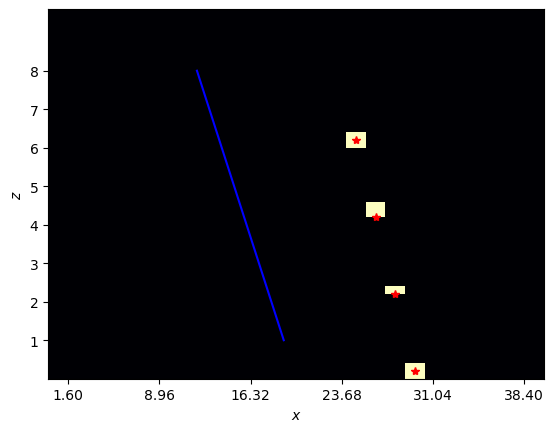

In [51]:
print(tt.get_tracks())
tt.print(True)

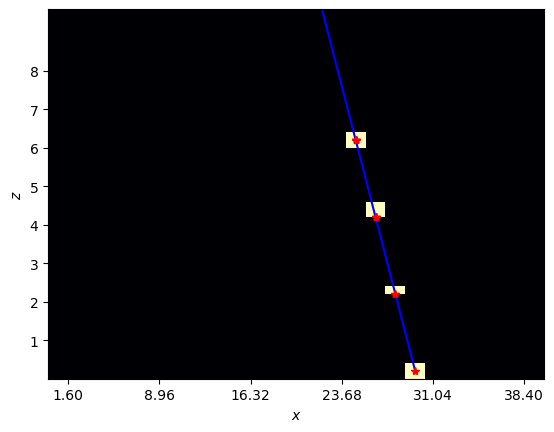

In [50]:
fig, axs = plt.subplots(1, 1)

fit = tt.get_tracks() #np.round(self.get_tracks())
# fit = [[int(f[0]), int(f[1])] for f in fit]
hitsX = [hit.get_pos()[0] for hit in tt.hits]
hitsZ = [hit.get_pos()[1] for hit in tt.hits]
bins_z = np.array([0])
for i in range(16):
    bins_z = np.append(bins_z,[bins_z[-1]+thickness, bins_z[-1]+thickness_screen])
            
axs.hist2d(hitsX, hitsZ, bins=[(np.linspace(0, 25, 26))*width, bins_z], cmap='magma')

axs.plot([coord_to_pos_x(f[0]) for f in fit], [coord_to_pos_z(f[1],True) for f in fit], 'b-')
plt.xticks(np.linspace(1, 24,6)*width)
plt.yticks(np.linspace(1, 8, 8)*(thickness_screen+thickness))
coords_x = []
coords_z = []
for i in tt.hits_index:
    if tt.hits[i].coord in fit:
        coords_x.append(tt.hits[i].get_pos()[0])
        coords_z.append(tt.hits[i].get_pos()[1])
    axs.plot(coords_x, coords_z, 'r*')
    axs.set(xlabel='$x$', ylabel='$z$')

(<Figure size 1920x800 with 1 Axes>, <Axes: >)

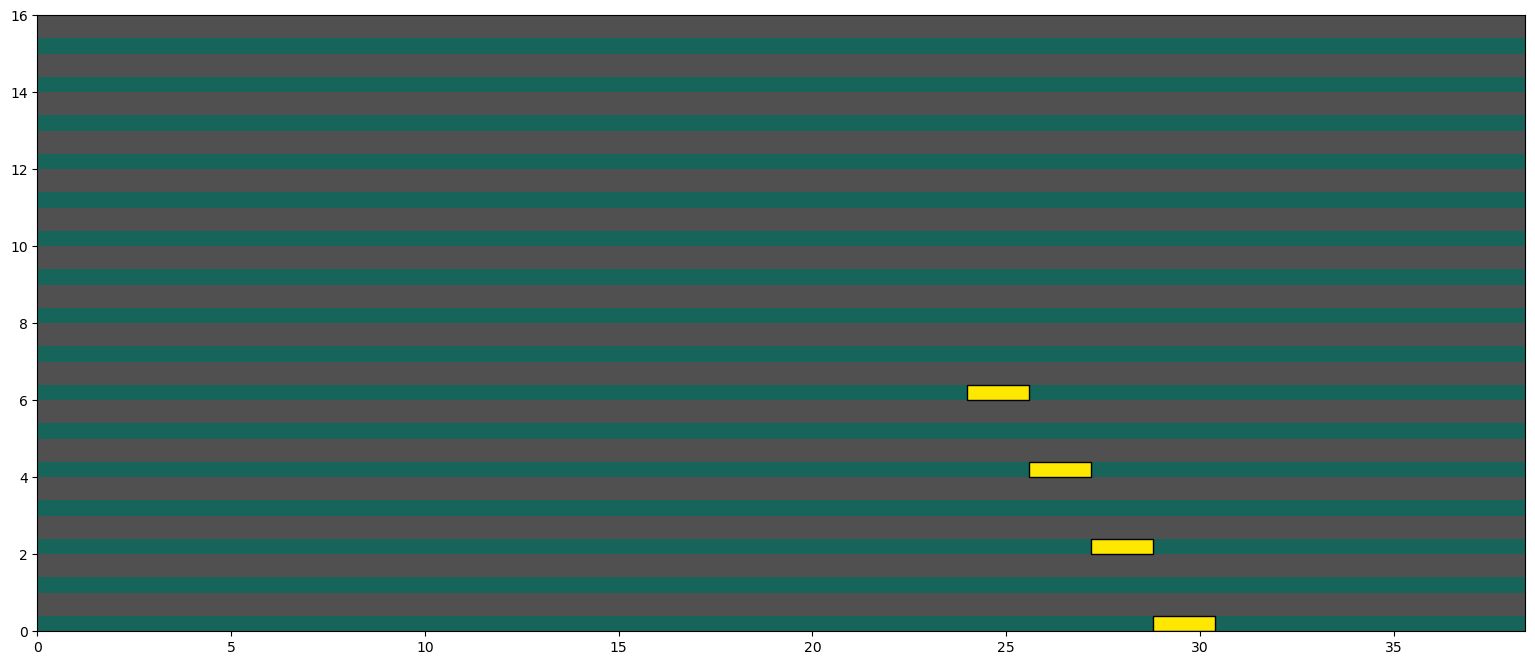

In [43]:
from track_reconstruction import *

plot_hits(tt.hits,True)